<a href="https://colab.research.google.com/github/sakethsridhara/Milwaukee_bearings/blob/main/latentSpaceBearingsPlotly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# run this first time to clone the directory
!git clone https://github.com/sakethsridhara/Milwaukee_bearings.git

Cloning into 'Milwaukee_bearings'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 49 (delta 14), reused 43 (delta 11), pack-reused 0
Receiving objects: 100% (49/49), 1.75 MiB | 7.33 MiB/s, done.
Resolving deltas: 100% (14/14), done.


In [4]:
from os import chdir # to alter your working directory
chdir('/content/Milwaukee_bearings') # setting the working directory to "dir1" in your drive
!pwd


/content/Milwaukee_bearings


In [11]:
import numpy as np
import pandas as pd
import torch
import os, sys
import time
import matplotlib.pyplot as plt
import matplotlib
from scipy.spatial import ConvexHull
from matplotlib.patches import Polygon, Ellipse
import plotly.graph_objects as go
sys.path.insert(0,'/content/Milwaukee_bearings/src/')
from utilFuncs import to_np, to_torch
from materialEncoder import MaterialEncoder
from smallestEllipse import *

import seaborn as sns
import scipy as sp


In [4]:
import datetime
from datetime import date
import pandas as pd
import numpy as np
from plotly import __version__
%matplotlib inline



### Spring database

In [5]:
def preprocessData():
  df = pd.read_excel('./data/bearingData.xlsx')
  dataIdentifier = {'classID':df[df.columns[0]],'name': df[df.columns[1]]} # name of the material and type
  trainInfo = np.log10(df[df.columns[2:]].to_numpy())
  dataScaleMax = torch.tensor(np.max(trainInfo, axis = 0))
  dataScaleMin = torch.tensor(np.min(trainInfo, axis = 0))
  normalizedData = (torch.tensor(trainInfo) - dataScaleMin)/(dataScaleMax - dataScaleMin)
  trainingData = normalizedData.clone().float()
  dataInfo = {'ID':{'idx':0,'scaleMin':dataScaleMin[0], 'scaleMax':dataScaleMax[0]},\
              'OD':{'idx':1,'scaleMin':dataScaleMin[1], 'scaleMax':dataScaleMax[1]},\
              'Width':{'idx':2,'scaleMin':dataScaleMin[2], 'scaleMax':dataScaleMax[2]},\
              'DynamicLoadRating':{'idx':3,'scaleMin':dataScaleMin[3], 'scaleMax':dataScaleMax[3]},\
              'StaticLoadRating':{'idx':4,'scaleMin':dataScaleMin[4], 'scaleMax':dataScaleMax[4]},\
              'RPM':{'idx':5,'scaleMin':dataScaleMin[5], 'scaleMax':dataScaleMax[5]},\
              'Cost':{'idx':6,'scaleMin':dataScaleMin[6], 'scaleMax':dataScaleMax[6]}}
  return trainingData, dataInfo, dataIdentifier, trainInfo
trainingData, dataInfo, dataIdentifier, trainInfo = preprocessData()
numMaterialsInTrainingData, numFeatures = trainingData.shape

In [6]:
latentDim = 2
hiddenDim = [250,250]
numEpochs = 30000
klFactor = 5e-5
learningRate = 2e-3
savedNet = './data/vaeNet.nt'
vaeSettings = {'encoder':{'inputDim':numFeatures, 'hiddenDim':hiddenDim,\
                                          'latentDim':latentDim},\
               'decoder':{'latentDim':latentDim, 'hiddenDim':hiddenDim,\
                                          'outputDim':numFeatures}}
materialEncoder = MaterialEncoder(trainingData, dataInfo, dataIdentifier, vaeSettings)
# materialEncoder.loadAutoencoderFromFile(savedNet)
start = time.perf_counter()
convgHistory = materialEncoder.trainAutoencoder(numEpochs, klFactor, savedNet, learningRate)
print('training time : {:.2F} '.format(time.perf_counter() - start))

Iter 0 reconLoss 6.72E+01 klLoss 9.61E-03 loss 6.73E+01
Iter 500 reconLoss 7.35E-01 klLoss 9.92E-02 loss 8.35E-01
Iter 1000 reconLoss 5.17E-01 klLoss 1.02E-01 loss 6.19E-01
Iter 1500 reconLoss 3.25E-01 klLoss 1.03E-01 loss 4.28E-01
Iter 2000 reconLoss 2.91E-01 klLoss 1.04E-01 loss 3.95E-01
Iter 2500 reconLoss 1.83E-01 klLoss 1.04E-01 loss 2.87E-01
Iter 3000 reconLoss 1.53E-01 klLoss 1.05E-01 loss 2.58E-01
Iter 3500 reconLoss 1.22E-01 klLoss 1.04E-01 loss 2.26E-01
Iter 4000 reconLoss 1.45E-01 klLoss 1.04E-01 loss 2.49E-01
Iter 4500 reconLoss 8.50E-02 klLoss 1.03E-01 loss 1.88E-01
Iter 5000 reconLoss 8.95E-02 klLoss 1.03E-01 loss 1.93E-01
Iter 5500 reconLoss 7.11E-02 klLoss 1.02E-01 loss 1.73E-01
Iter 6000 reconLoss 5.96E-02 klLoss 1.01E-01 loss 1.61E-01
Iter 6500 reconLoss 6.06E-02 klLoss 1.01E-01 loss 1.61E-01
Iter 7000 reconLoss 7.02E-02 klLoss 1.01E-01 loss 1.71E-01
Iter 7500 reconLoss 8.03E-02 klLoss 1.00E-01 loss 1.81E-01
Iter 8000 reconLoss 5.25E-02 klLoss 9.95E-02 loss 1.52E-01
I

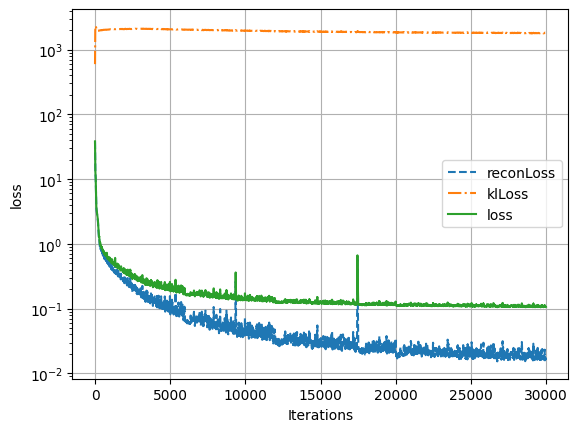

In [11]:
def plotConvergence(convg):
  plt.figure();
  strokes = ['--', '-.', '-', ':']
  for ctr, key in enumerate(convg):
    y = torch.as_tensor(convg[key]).detach().numpy()
    y_mvavg = np.convolve(y, np.ones(20), 'valid') / 20.
    plt.semilogy(y_mvavg, strokes[ctr], label = str(key))
    plt.xlabel('Iterations')
    plt.ylabel(str(key))
    plt.grid('True')
    plt.legend()



  # plotly_fig = tls.mpl_to_plotly(f1) ## convert
  # iplot(plotly_fig)
plotConvergence(convgHistory)

In [22]:
def plotConvergence2(convg):
    fig = go.Figure()
    strokes = ['dash', 'dashdot', 'solid', 'dot']  # Corresponding to ['--', '-.', '-', ':']

    for ctr, key in enumerate(convg):
        y = torch.as_tensor(convg[key]).detach().numpy()
        y_mvavg = np.convolve(y, np.ones(20), 'valid') / 20.

        fig.add_trace(go.Scatter(
            x=list(range(len(y_mvavg))),
            y=y_mvavg,
            mode='lines',
            line=dict(dash=strokes[ctr], width=2),
            name=str(key)
        ))

    fig.update_layout(
        xaxis_title='Iterations',
        yaxis_title=str(key),
        showlegend=True,
        legend=dict(orientation="h", x=0.1, y=1.1),
        yaxis_type="log")

    fig.show(renderer='colab')

# Example usage
# Assuming 'convg' is a dictionary with keys and corresponding lists of convergence data
plotConvergence2(convgHistory)


In [23]:
matidxs = np.arange(trainInfo.shape[0]).astype(int)
props = ['ID','OD','Width','StaticLoadRating','DynamicLoadRating','RPM','Cost']
# print([dataIdentifier['name'][i] for i in matidxs])
# print('\t \t ------TRUE DATA----------')
# print('Catalog Name', end = '\t')
# for p in props:
#     print(p, end = '\t')
# for i in matidxs:
#   print(f"\n {dataIdentifier['name'][i]} \t ", end = '')
#   for p in props:
#     idx = materialEncoder.dataInfo[p]['idx']
#     print('\t {:.2E}'.format(10.**trainInfo[i,idx]),end='')

def unnormalize(val, minval ,maxval):
  return 10.**(minval + (maxval-minval)*val)
def decodeAll():
  vae = materialEncoder.vaeNet
  decoded = vae.decoder(vae.encoder.z)
  matProp = {'ID':None,'OD':None,'Width':None,'StaticLoadRating':None,'DynamicLoadRating': None, 'RPM':None,'Cost':None}

  for k in props:
    idx = materialEncoder.dataInfo[k]['idx']
    scaleMax = materialEncoder.dataInfo[k]['scaleMax']
    scaleMin = materialEncoder.dataInfo[k]['scaleMin']
    matProp[k] = unnormalize(decoded[:,idx], scaleMin ,scaleMax)#scaleMin + decoded[:,idx]*(scaleMax - scaleMin)
  return matProp

matProp = decodeAll()
# print('\n \n \t \t ------RECONSTRUCTED DATA----------')
# print('Catalog Name', end = '\t')
# for p in props:
#     print(p, end = '\t')

# for i in matidxs:
#   print(f"\n {dataIdentifier['name'][i]} \t ", end = '')
#   for p in props:
#     print('\t {:.2E}'.format(matProp[p][i]), end='')

merr = -1000000000.

maxError = {'ID':merr,'OD':merr,'Width':merr,'StaticLoadRating':merr,'DynamicLoadRating':merr, 'RPM':merr,'Cost':merr}
print('\n \n \t \t ------RECON ERROR (%)----------')
print('Catalog name', end = '\t')
errList = torch.zeros(trainInfo.shape[0],7);
for p in props:
    print(f"\t{p}", end = '\t')
for i in range(trainInfo.shape[0]):
  count = 0;

  if(i in matidxs): #
    print(f"\n  {dataIdentifier['name'][i]} ", end = '')

  for p in props:
    idx = materialEncoder.dataInfo[p]['idx']
    trueData = 10**trainInfo[i,idx]
    reconData = matProp[p][i]
    err = torch.abs(100.*(trueData - reconData)/trueData).to('cpu')
    errList[i,count] = err
    count = count + 1;
    if(err > maxError[p]):
      maxError[p] = err
    if(i in matidxs):
      print('\t {:.1F} \t'.format(err), end='')


print('\n max Error', end = '')
for p in props:
  print('\t {:.1F}'.format(maxError[p]), end='')

print("\n Mean Error:")
print(torch.mean(errList,0))


 
 	 	 ------RECON ERROR (%)----------
Catalog name		ID		OD		Width		StaticLoadRating		DynamicLoadRating		RPM		Cost	
  60355K124 	 0.0 		 0.5 		 0.1 		 1.4 		 1.0 		 0.2 		 0.2 	
  60355K132 	 0.4 		 0.6 		 1.2 		 0.1 		 2.0 		 0.6 		 0.4 	
  60355K151 	 0.8 		 1.1 		 0.1 		 1.5 		 0.6 		 0.2 		 1.1 	
  60355K165 	 0.5 		 0.4 		 0.0 		 0.8 		 3.0 		 1.3 		 0.8 	
  60355K173 	 1.5 		 1.6 		 0.4 		 3.8 		 5.4 		 0.3 		 0.9 	
  60355K178 	 0.7 		 0.4 		 1.8 		 0.9 		 0.8 		 1.8 		 0.7 	
  60355K185 	 0.2 		 1.2 		 1.2 		 1.5 		 3.2 		 0.4 		 0.5 	
  60355K508 	 2.4 		 0.5 		 0.3 		 0.2 		 1.2 		 2.1 		 0.7 	
  60355K509 	 2.2 		 0.4 		 1.3 		 0.7 		 1.0 		 0.2 		 1.1 	
  60355K211 	 0.0 		 0.3 		 0.2 		 0.3 		 0.8 		 1.7 		 0.9 	
  60355K22 	 0.2 		 0.4 		 1.0 		 2.1 		 1.6 		 1.0 		 0.8 	
  60355K511 	 0.2 		 0.2 		 0.5 		 1.2 		 0.6 		 0.7 		 1.6 	
  60355K512 	 0.1 		 1.1 		 1.5 		 3.9 		 2.1 		 0.6 		 2.6 	
  5972K91 	 0.0 		 0.5 		 0.5 		 0.0 		 1.2 		 0.6 		 1.1 	
  5972K93 	 2.7 		

In [7]:
def plotLatent(annotateHead, saveFileName):
    clrs = ['blue', 'green']
    mrkrSet = ['*','D']
    colorcol = dataIdentifier['classID']
    ptLabel = dataIdentifier['name']
    autoencoder = materialEncoder.vaeNet
    z = autoencoder.encoder.z.to('cpu').detach().numpy()
    fig, ax = plt.subplots()
    for i in range(np.max(colorcol)+1):
      zMat = np.vstack((z[colorcol == i,0], z[colorcol == i,1])).T
      ax.scatter(zMat[:, 0], zMat[:, 1], marker=mrkrSet[i], c = clrs[i], s = 12)#clrs[i]

      hull = ConvexHull(zMat)
      cent = np.mean(zMat, 0)
      pts = []
      for pt in zMat[hull.simplices]:
          pts.append(pt[0].tolist())
          pts.append(pt[1].tolist())

      pts.sort(key=lambda p: np.arctan2(p[1] - cent[1],
                                      p[0] - cent[0]))
      pts = pts[0::2]  # Deleting duplicates
      # pts.insert(len(pts), pts[0])
      enclosing_ellipse = welzl(np.array(pts, dtype=float))
      # plot resulting ellipse
      center,a,b,t = enclosing_ellipse
      # elli = plot_ellipse(enclosing_ellipse, str='k')
      # ellipse = Ellipse(xy=center, width=2*a, height=2*b, angle=np.degrees(t), edgecolor='k', fc=clrs[i], alpha=0.3, lw=2)
      # ax.add_patch(ellipse)

      # ax.annotate('Ball Bearings', xy=(-1, -1.5), xytext=(-3,-2), size = 14, c = 'black', xycoords='data',textcoords='data',arrowprops=dict(arrowstyle="-"))
      # ax.annotate('Roller Bearings', xy=(1,1.8), xytext=(1.2,2),size = 14, c = 'black', xycoords='data',textcoords='data',arrowprops=dict(arrowstyle="-"))
      # plt.show()



    matidxs = [ ]
    for i, txt in enumerate(ptLabel):
      if(annotateHead == False or ( annotateHead == True and  i in matidxs)):

        ax.annotate(txt, (z[i,0], z[i,1]), size = 10)
        ax.scatter(z[i,1], z[i,0], marker='*', c = 'red', s = 56)

    ticks = [-3, -2,  -1., 0.,  1., 2, 3]
    ticklabels = ['-3','-2', '-1', '0','1', '2','3']
    plt.xticks(ticks, ticklabels, fontsize=18)
    plt.yticks(ticks, ticklabels, fontsize=18)
    plt.xlabel('z{:d}'.format(0), size = 18)
    plt.ylabel('z{:d}'.format(1), size = 18)
    minor_ticks = np.arange(-3, 3, 0.1)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_yticks(minor_ticks, minor=True)
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_aspect('equal', 'box')

    plt.grid(visible=None)
    plt.savefig(saveFileName,bbox_inches='tight')

    return fig, ax



(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='z0', ylabel='z1'>)

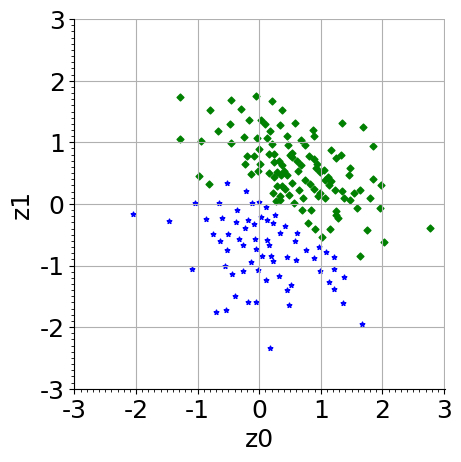

In [8]:
plotLatent(annotateHead = True, saveFileName = './figures/Bearinglatent.pdf')

In [1]:
def plotlyLatent(annotateHead):
    clrs = ['blue', 'green']
    mrkrSet = ['*','D']
    colorcol = dataIdentifier['classID']
    ptLabel = dataIdentifier['name']
    autoencoder = materialEncoder.vaeNet
    z = autoencoder.encoder.z.to('cpu').detach().numpy()
    print(z)
    scatter_traces = []
    for i in range(np.max(colorcol)+1):
      zMat = np.vstack((z[colorcol == i,0], z[colorcol == i,1])).T

      scatter_trace = go.Scatter(
    x=zMat[:, 0],
    y=zMat[:, 1],
    mode='markers',
    marker=dict(
        size=8,
        color=clrs[i],
        colorscale='Viridis',
        opacity=0.7
    )
)
      scatter_traces.append(scatter_trace)


      # ax.scatter(zMat[:, 0], zMat[:, 1], marker=mrkrSet[i], c = clrs[i], s = 12)#clrs[i]

      hull = ConvexHull(zMat)
      cent = np.mean(zMat, 0)
      pts = []
      for pt in zMat[hull.simplices]:
          pts.append(pt[0].tolist())
          pts.append(pt[1].tolist())

      pts.sort(key=lambda p: np.arctan2(p[1] - cent[1],
                                      p[0] - cent[0]))
      pts = pts[0::2]  # Deleting duplicates
      # pts.insert(len(pts), pts[0])
      enclosing_ellipse = welzl(np.array(pts, dtype=float))
      # plot resulting ellipse
      center,a,b,t = enclosing_ellipse

      elli = sample_ellipse(enclosing_ellipse,1000)
      # ellipse = Ellipse(xy=center, width=2*a, height=2*b, angle=np.degrees(t), edgecolor='k', fc=clrs[i], alpha=0.3, lw=2)
      # ax.add_patch(ellipse)
      scatter_trace = go.Scatter(
          x=elli[:, 0],
          y=elli[:, 1],
          mode='lines',
          marker=dict(
              size=8,
              color=clrs[i],
              colorscale='Viridis',
              opacity=0.7,
          )
      )
      scatter_traces.append(scatter_trace)


      # ax.annotate('Ball Bearings', xy=(-1, -1.5), xytext=(-3,-2), size = 14, c = 'black', xycoords='data',textcoords='data',arrowprops=dict(arrowstyle="-"))
      # ax.annotate('Roller Bearings', xy=(1,1.8), xytext=(1.2,2),size = 14, c = 'black', xycoords='data',textcoords='data',arrowprops=dict(arrowstyle="-"))
      # plt.show()



    # matidxs = [ ]
    # for i, txt in enumerate(ptLabel):
    #   if(annotateHead == False or ( annotateHead == True and  i in matidxs)):

    #     ax.annotate(txt, (z[i,0], z[i,1]), size = 10)
    #     ax.scatter(z[i,1], z[i,0], marker='*', c = 'red', s = 56)

    # ticks = [-3, -2,  -1., 0.,  1., 2, 3]
    # ticklabels = ['-3','-2', '-1', '0','1', '2','3']
    # plt.xticks(ticks, ticklabels, fontsize=18)
    # plt.yticks(ticks, ticklabels, fontsize=18)
    # plt.xlabel('z{:d}'.format(0), size = 18)
    # plt.ylabel('z{:d}'.format(1), size = 18)
    # minor_ticks = np.arange(-3, 3, 0.1)
    # ax.set_xticks(minor_ticks, minor=True)
    # ax.set_yticks(minor_ticks, minor=True)
    # # Hide the right and top spines
    # ax.spines['right'].set_visible(False)
    # ax.spines['top'].set_visible(False)
    # ax.set_aspect('equal', 'box')

    # plt.grid(visible=None)
    # scatter_plotly.show(renderer='colab')

    scatter_plotly = go.Figure(data=scatter_traces)
    scatter_plotly.update_layout(plot_bgcolor='white')
    scatter_plotly.update_layout(title='Latent Space of Bearings')
    scatter_plotly.update_layout(xaxis_range=[-3, 3],  # Set the x-axis limits
        yaxis_range=[-3, 3], width = 800, height = 800);
    scatter_plotly.update_xaxes(
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
    )
    scatter_plotly.update_yaxes(
        mirror=True,
        ticks='outside',
        showline=True,
        linecolor='black',
        gridcolor='lightgrey'
    )
    scatter_plotly.show(renderer='colab')
    return 0



In [2]:
plotlyLatent(annotateHead = True)

NameError: ignored

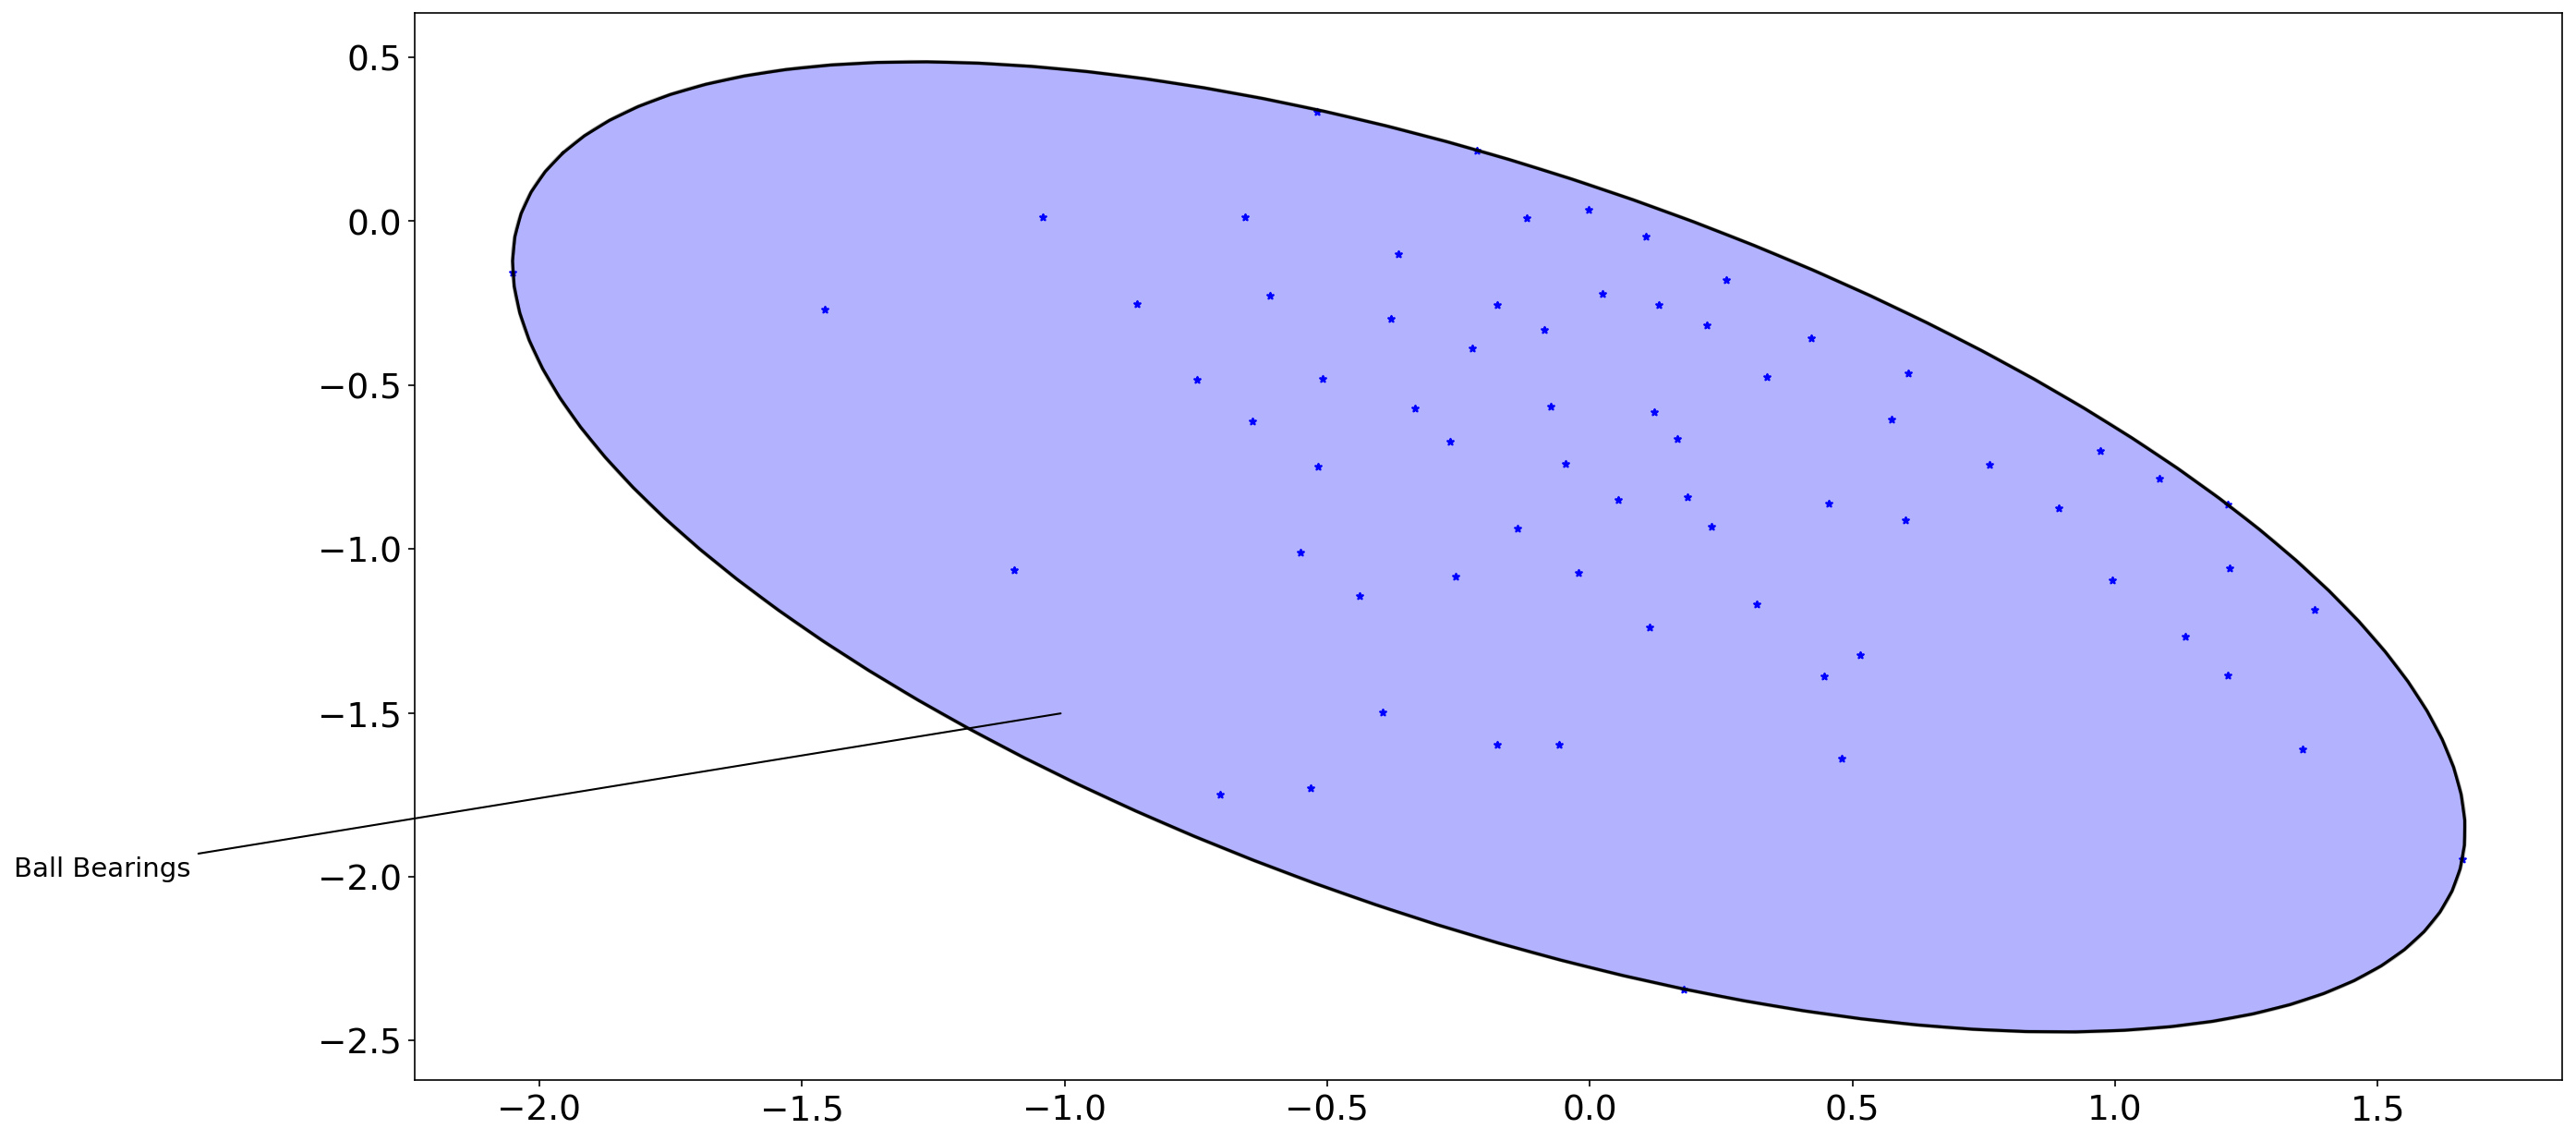

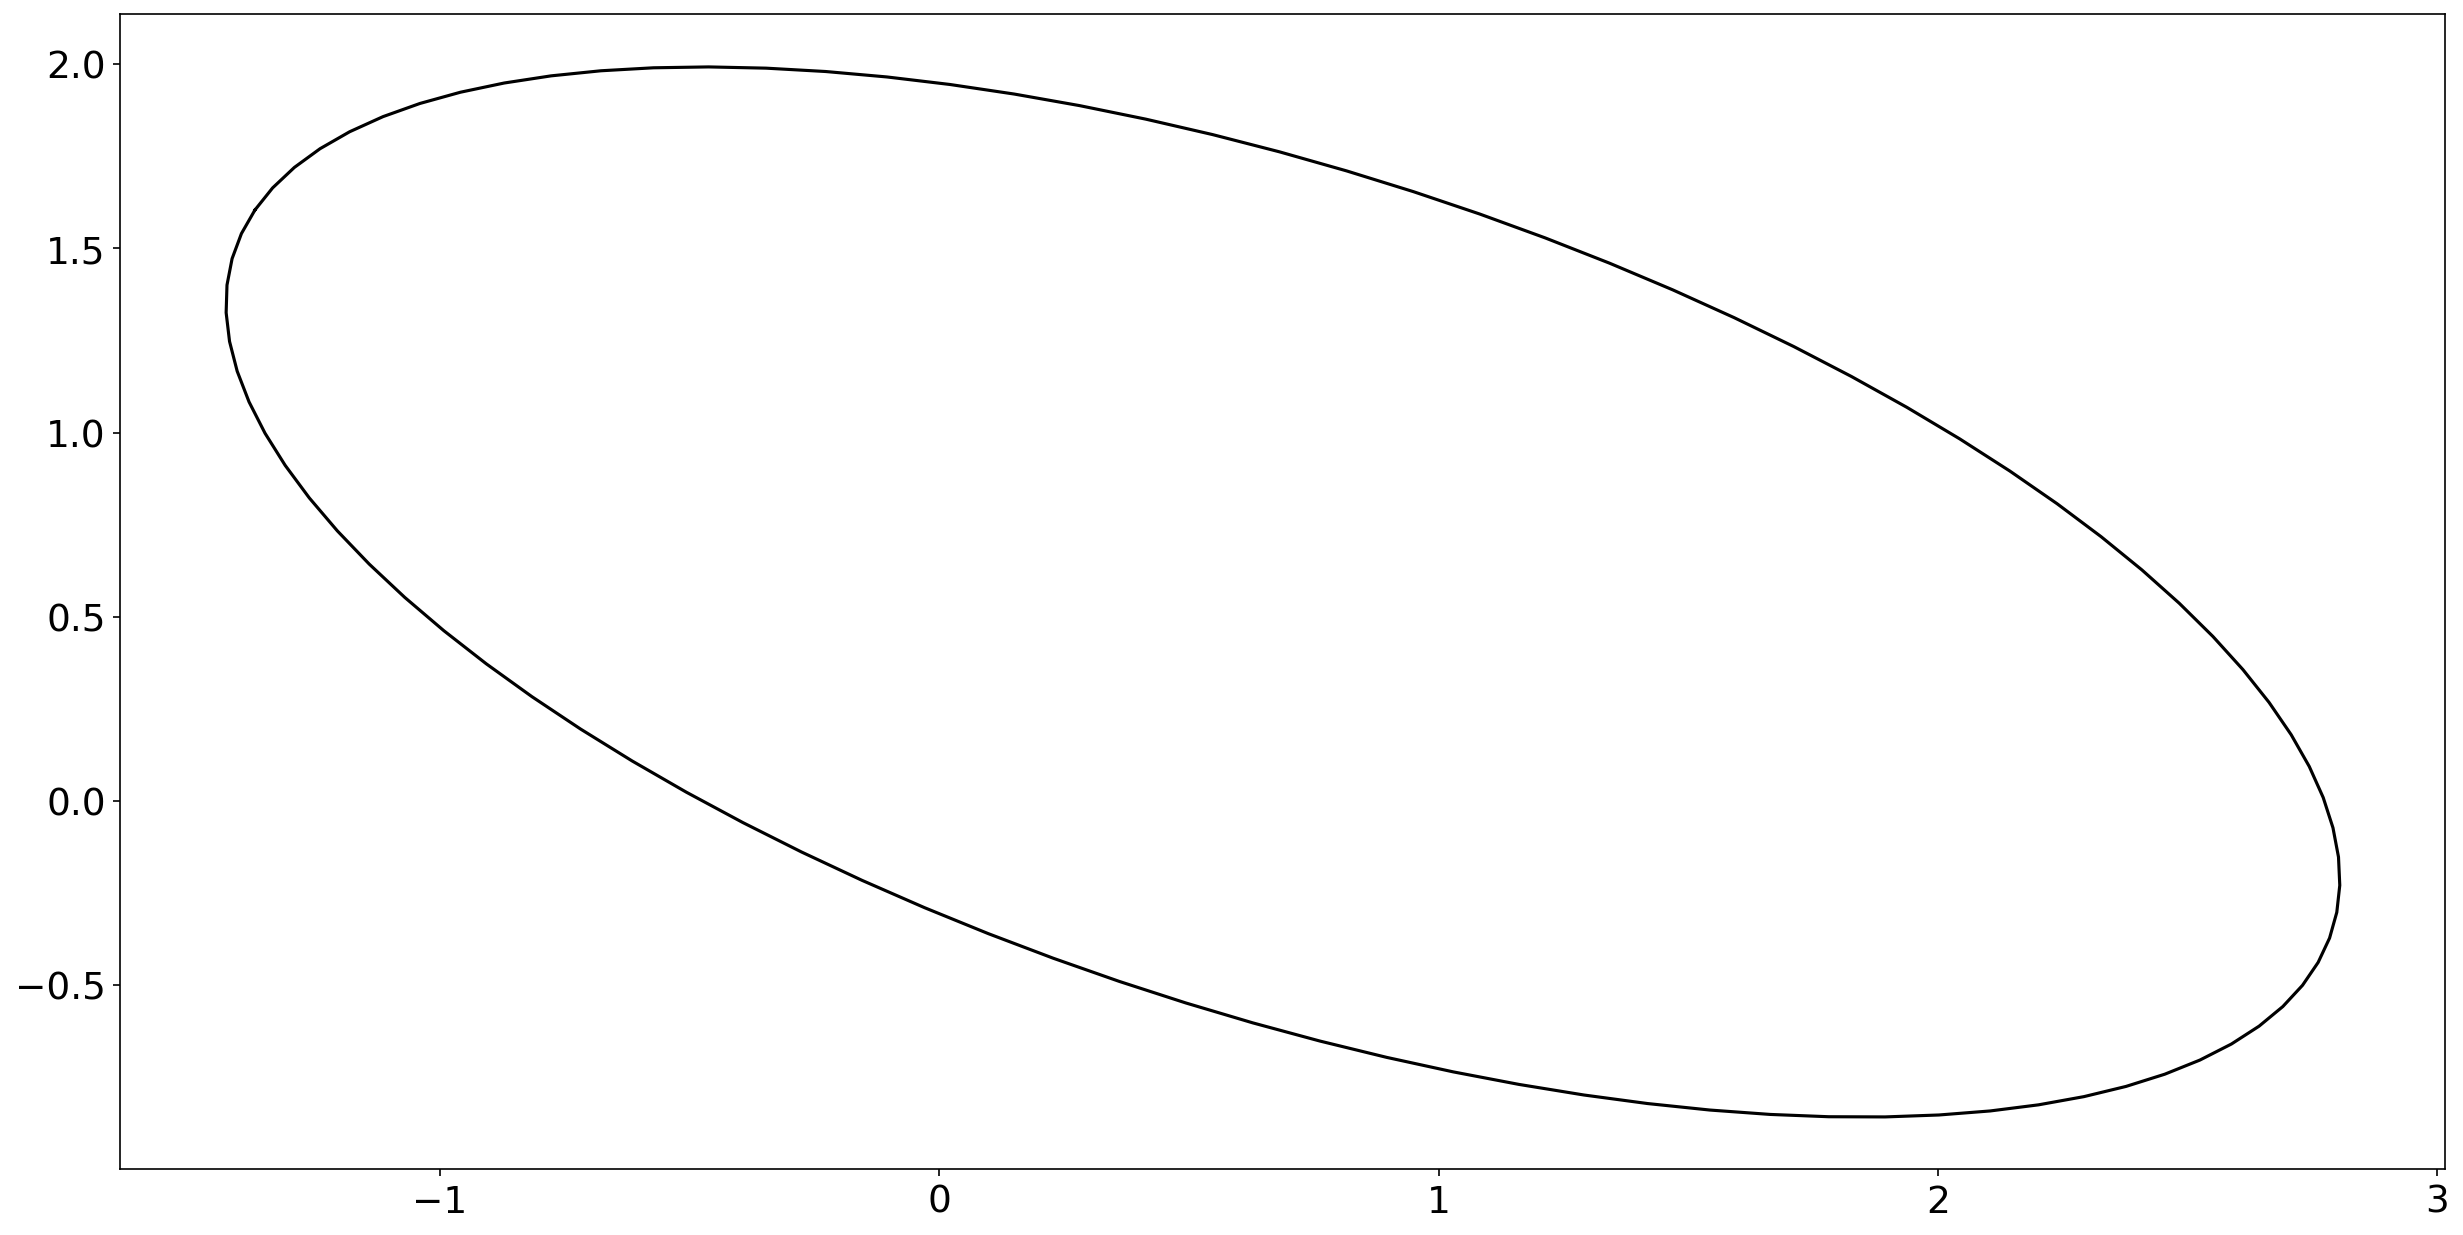

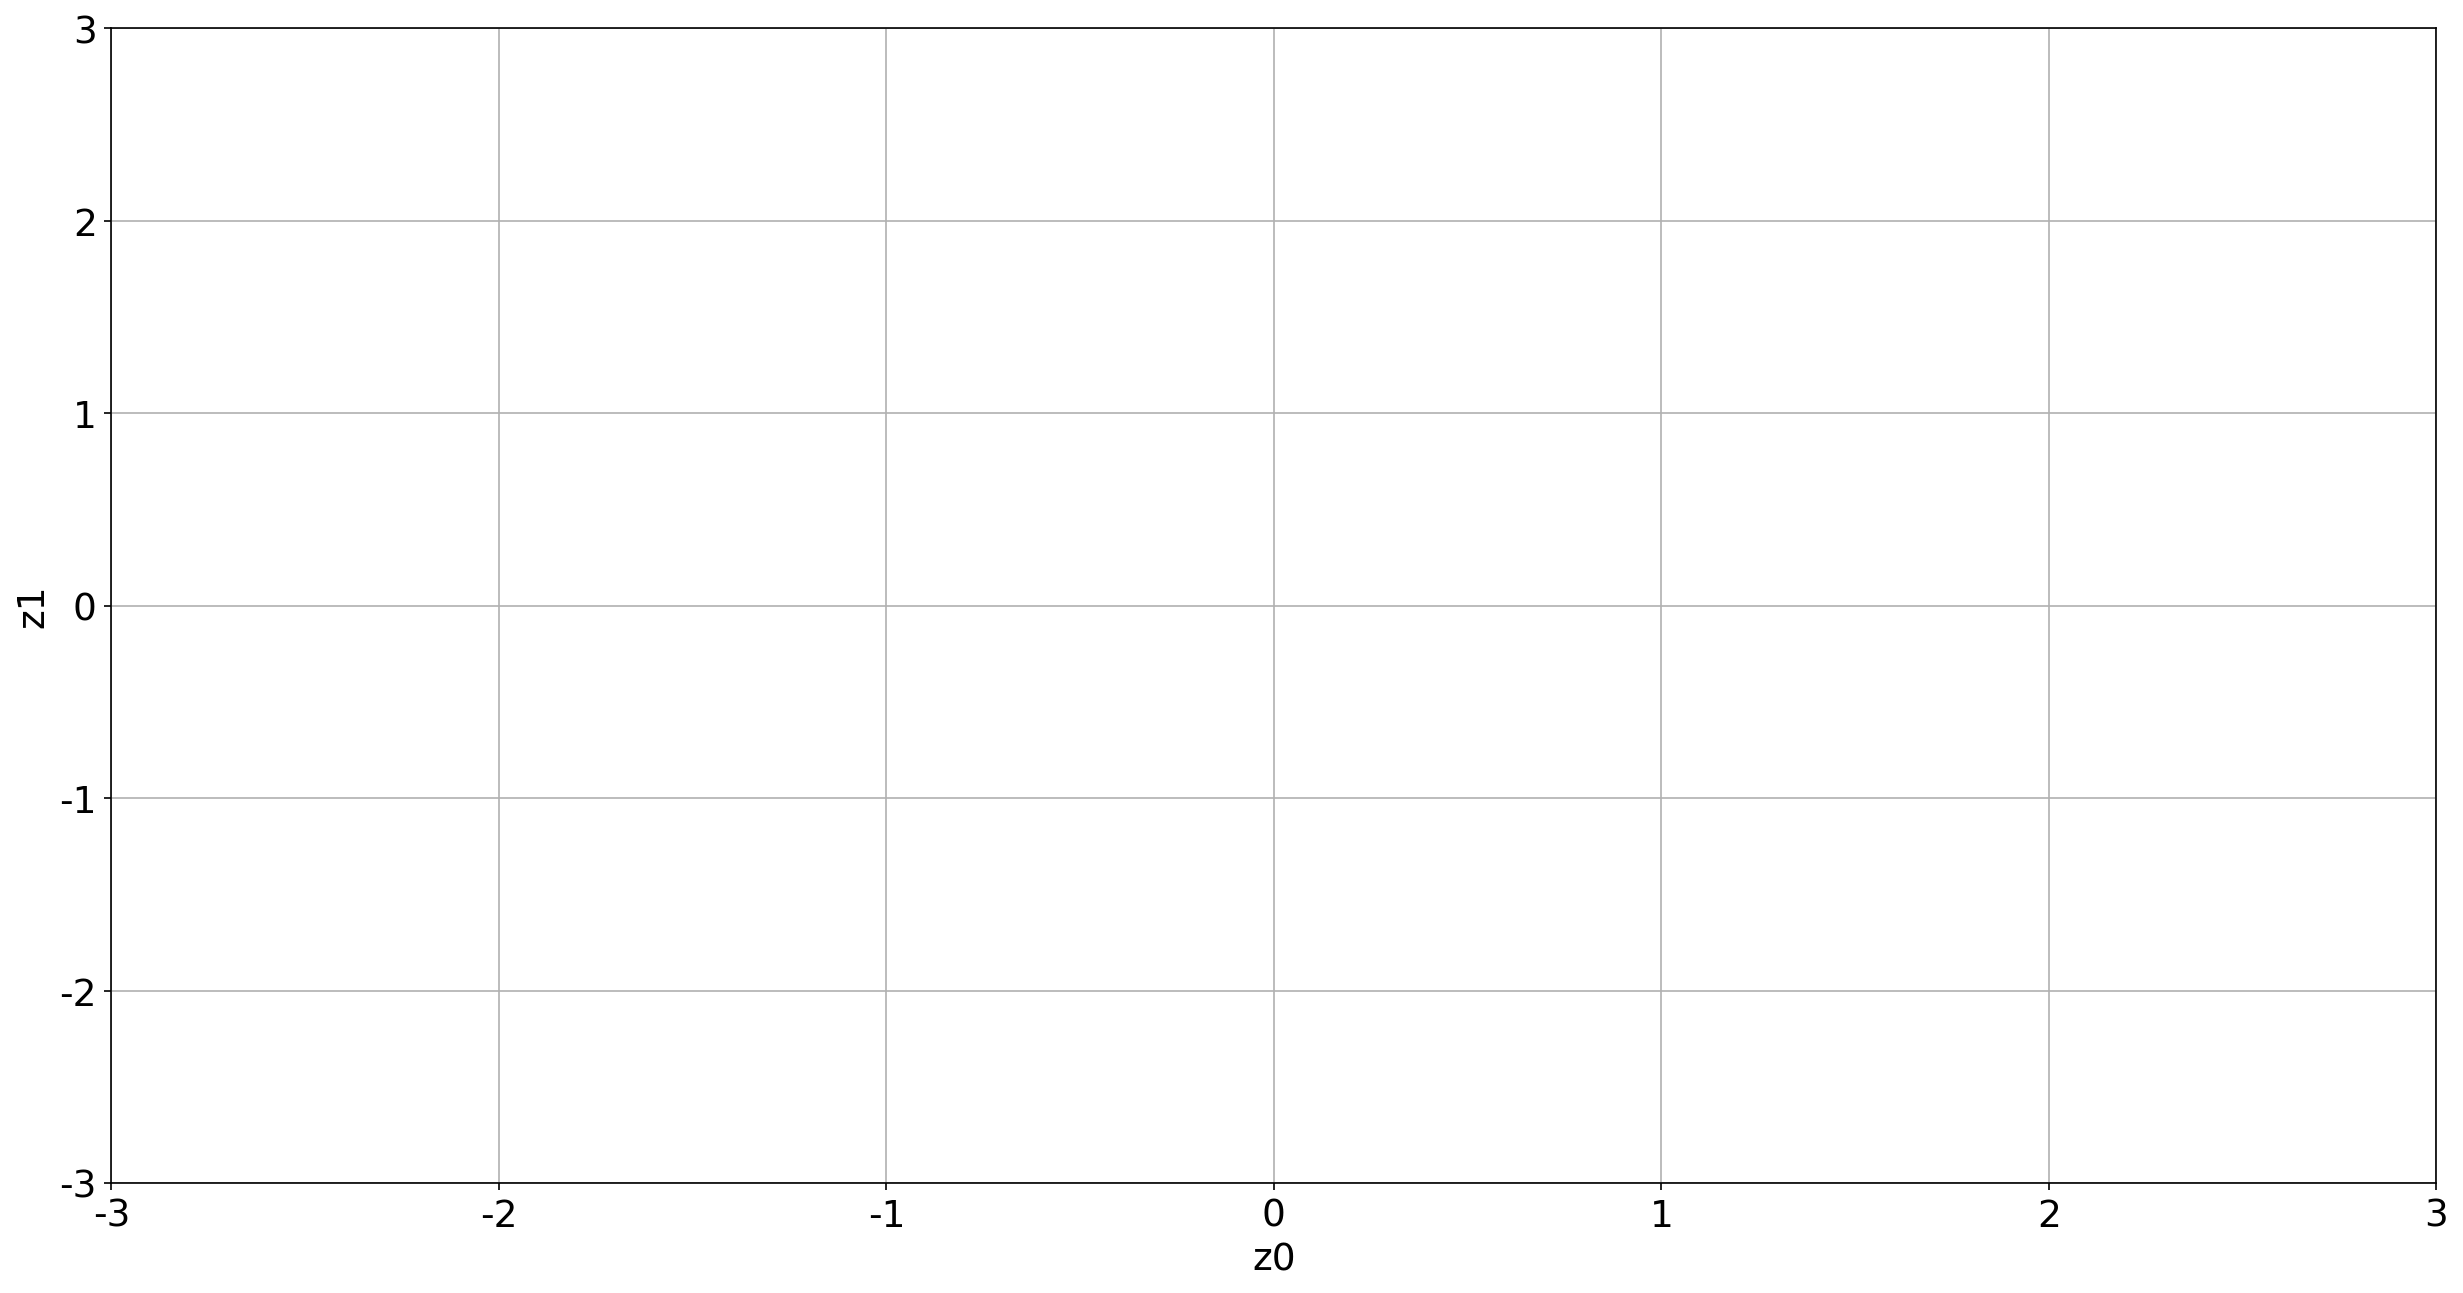

<Figure size 3000x1500 with 0 Axes>

In [22]:
def plotLatentWithPropertyNew(ltnt1 = 0, ltnt2 = 1):
  n = 80
  zmin, zmax = -3,3
  X,Y = np.meshgrid(np.linspace(zmin, zmax, n), np.linspace(zmin, zmax, n))
  Z = torch.zeros((n**2, vaeSettings['encoder']['latentDim'])).to('cpu')
  Z[:,ltnt1], Z[:,ltnt2] = to_torch(X.reshape(-1)), to_torch(Y.reshape(-1))

  vae = materialEncoder.vaeNet.to('cpu')
  trainData_z_np = to_np(vae.encoder.z)
  decoded = vae.decoder(Z)



  #-------------------------------------------#
  props = ['RPM']
  cutOff = [30000,40000];

  for p in props:
    idx = materialEncoder.dataInfo[p]['idx']
    scaleMax = materialEncoder.dataInfo[p]['scaleMax']
    scaleMin = materialEncoder.dataInfo[p]['scaleMin']

    matPropVal = to_np(10.**(scaleMin + decoded[:,idx]*(scaleMax - scaleMin)))
    levs = np.logspace(np.log10(min(matPropVal))*0.5, np.log10(max(matPropVal)), 40)
    fig, ax = plotLatent(0, 1, plotHull = False, plotEllipse = True, annotateHead = True, saveFileName = './figures/Bearinglatent.pdf')
    # surf = ax.contour(X, Y, (matPropVal.reshape((n,n))), levels = levs, cmap='viridis_r', alpha = 0.6)

    # surf = ax.contour(X, Y, (to_np(matPropVal).reshape((n,n))), levels = cutOff, cmap='coolwarm', alpha = 0.3)

    surf = ax.contourf(X, Y, (matPropVal.reshape((n,n))), levels = cutOff, alpha = 0.2,\
    colors=['g', 'g', '#C0C0C0'], extend='both')
    surf.cmap.set_over('white')
    surf.cmap.set_under('white')
    surf.changed()



    plt.clabel(surf, inline=False, fontsize=12, fmt ='%0.2f', colors = 'black')
    ax.set_xlabel('$z_0$')
    ax.set_ylabel('$z_1$')
    ax.set_title(p)
    cbar = plt.colorbar(surf)
    cbar.set_label('({:s})'.format(str(p)))
    plt.show()
    plt.savefig('./figures/{:s}_latentFieldContours.pdf'.format(p), dpi=200, bbox_inches='tight')

  #-------------------------------------------#


plt.close('all')
plotLatentWithPropertyNew()

In [ ]:
def plotLatentWithPropertyNew(ltnt1 = 0, ltnt2 = 1):
  n = 80
  zmin, zmax = -3,3
  X,Y = np.meshgrid(np.linspace(zmin, zmax, n), np.linspace(zmin, zmax, n))
  Z = torch.zeros((n**2, vaeSettings['encoder']['latentDim'])).to('cpu')
  Z[:,ltnt1], Z[:,ltnt2] = to_torch(X.reshape(-1)), to_torch(Y.reshape(-1))

  vae = materialEncoder.vaeNet.to('cpu')
  trainData_z_np = to_np(vae.encoder.z)
  decoded = vae.decoder(Z)



  #-------------------------------------------#
  props = ['ID','RPM']
  cutOff = [[0.25,1.0],[30000,40000]];
  fig, ax = plotLatent(ltnt1 = ltnt1, ltnt2 = ltnt2, plotHull = False, plotEllipse=True, annotateHead = False, saveFileName = './figures/SpringLatent.pdf')
  cols = ['g','b']

  i = 0
  for p in props:
    idx = materialEncoder.dataInfo[p]['idx']
    scaleMax = materialEncoder.dataInfo[p]['scaleMax']
    scaleMin = materialEncoder.dataInfo[p]['scaleMin']

    matPropVal = to_np(10.**(scaleMin + decoded[:,idx]*(scaleMax - scaleMin)))


    levs = np.logspace(np.log10(min(matPropVal))*0.5, np.log10(max(matPropVal)), 20)
    surf = ax.contourf(X, Y, ((matPropVal).reshape((n,n))), levels = cutOff[i], alpha = 0.4, colors=[cols[i],cols[i]], extend='both')
    i+=1;

    # surf = ax.contour(X, Y, (matPropVal).reshape((n,n)), levels = cutOff, cmap='viridis_r', alpha = 0.6)
    surf.cmap.set_over('white')
    surf.cmap.set_under('white')
    surf.changed()

    plt.clabel(surf, inline=False, fontsize=10, fmt ='%0.0f', colors = 'black')
    ax.set_xlabel('$z_0$')
    ax.set_ylabel('$z_1$')
    ax.set_title('Bearing selector: ID:0.25-1 in & ROM: 30000-40000')
    cbar = plt.colorbar(surf, pad=0.01)
    plt.clabel(surf, inline=False, fontsize=10, fmt ='%0.2f', colors = 'black')
    cbar.set_label('({:s})'.format(str(p)), rotation=270, labelpad=0)
    plt.show()

    plt.savefig('./figures/{:s}Combined_latentField.pdf'.format(p), dpi=200, bbox_inches='tight')

  #-------------------------------------------#


plt.close('all')
plotLatentWithPropertyNew()